# Summary of Findings

### Introduction
This project explores ethnic biases in terms of Board Disposition outcomes and complainant age with respect to the ethnicity of the complainant. The dataset has data on complaints registered against the NYPD including the complainants race, gender, age, etc. It relates to the question I am investigating because it has data on complaints as well as their board disposition outcomes.

### Cleaning and EDA
The first step was to look at the few columns needed in detail. The board_disposition column was simplified to having just 3 possible values as that is what was needed for this analysis.
The ethnicity column had entries like "Unknown" that were converted to null values for later analysis. The age column had some negative values that were filtered out of the dataset. The values in the column were made sure to be whole numbers and that the distribution was fairly normal.

### Assessment of Missingness
The first assessment of missingness was determining if the ethnicity column was MAR dependent on the board disposition outcome. The test stat was taken as TVD and simulating 1000 time revealed that the observed TVD was a very rare to never occuring occurance so it could be said that there is some dependence. This conclusion would affect the accuracy of any inferences made based on solely these 2 columns as the null values cannot be dropped while preserving a reflection of reality.
The second assessment was between precinct and board_disposition outcome as these shouldn't have any relation trivially speaking. This was backed up after carrying a simulation similar to the first assessment as the p-value was found to be too big to reject the idea that there is no dependence. 
Statistically speaking, these results are reliable for this dataset as the number of simulations was high.

### Hypothesis Test
The null hypothesis was Younger complainants get their complaints Exonerated roughly the same as they get it Substantiated and the alternate hypothesis was Younger complainants are more likely to get their complaints Exonerated than Substantiated. The test statistic used was a difference of means. The significance level used was 0.05 and the conclusion that can be obtained from a p-value of less than that is that we reject the null hypothesis. There is likely a change in likelihood of outcome of disposition depending on age.

# Code

In [227]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scipy.stats import ks_2samp
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Cleaning and EDA

In [188]:
df = pd.read_csv('allegations_202007271729.csv')
df.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A)


Checking the various entries of the board_disposition column.

In [189]:
df['board_disposition'].unique()

array(['Substantiated (Command Lvl Instructions)',
       'Substantiated (Charges)', 'Substantiated (Command Discipline A)',
       'Substantiated (Formalized Training)', 'Unsubstantiated',
       'Exonerated', 'Substantiated (Command Discipline B)',
       'Substantiated (Instructions)',
       'Substantiated (Command Discipline)',
       'Substantiated (No Recommendations)',
       'Substantiated (MOS Unidentified)'], dtype=object)

We see that there are many entries for 'Substantiated' but for the purposes of this analysis they all represent the same thing. Cleaning this column:

In [190]:
def clean_board_disposition(arg):
    if 'Substantiated' in arg:
        return 'Substantiated'
    else:
        return arg

In [191]:
df['board_disposition'] = df['board_disposition'].apply(clean_board_disposition)
df['board_disposition'].unique()

array(['Substantiated', 'Unsubstantiated', 'Exonerated'], dtype=object)

Now taking a look at the ethnicity column:

In [192]:
df['complainant_ethnicity'].unique()

array(['Black', nan, 'White', 'Asian', 'Refused', 'Hispanic', 'Unknown',
       'Other Race', 'American Indian'], dtype=object)

For the purposes of this analysis, the entries 'Refused' and 'Unknown'  are essentially null values.

In [193]:
def clean_ethnicity(arg):
    if arg in ['Refused', 'Unknown']:
        return np.nan
    else:
        return arg
df['complainant_ethnicity'] = df['complainant_ethnicity'].apply(clean_ethnicity)
df['complainant_ethnicity'].unique()

array(['Black', nan, 'White', 'Asian', 'Hispanic', 'Other Race',
       'American Indian'], dtype=object)

Age column:

In [194]:
df['complainant_age_incident'].isnull().sum()

4812

In [195]:
df['complainant_age_incident'].dtype

dtype('float64')

We see that the type of this column is float64 which means that all values are numeric but might mean that some value is not a whole number.

In [196]:
np.array_equal(df['complainant_age_incident'].dropna(), 
               df['complainant_age_incident'].dropna().astype(int))

True

Seeing that converting to int does not change the numeric value of each age, we then check for irregularities in the column by looking at its statistics and plotting the distribution.

In [197]:
df['complainant_age_incident'].describe()

count    28546.000000
mean        32.484201
std         28.408963
min      -4301.000000
25%         23.000000
50%         30.000000
75%         41.000000
max        101.000000
Name: complainant_age_incident, dtype: float64

The min age of -4301 does not make sense so we remove all negative age values from the dataframe. The max age of 101 is also interesting but it is still feasibly true so we do keep that in the data. 

We do not want to remove null values of age just yet so we add a new column to help with the removal rather than using .loc on the complainant_age_incident column.

In [198]:
df['bad_age'] = df['complainant_age_incident'] < 0 
df = df.loc[df['bad_age'] == False]
df['complainant_age_incident'].describe()

count    28540.000000
mean        32.641906
std         12.206667
min          0.000000
25%         23.000000
50%         30.000000
75%         41.000000
max        101.000000
Name: complainant_age_incident, dtype: float64

/Users/aryamansinha/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/aryamansinha/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


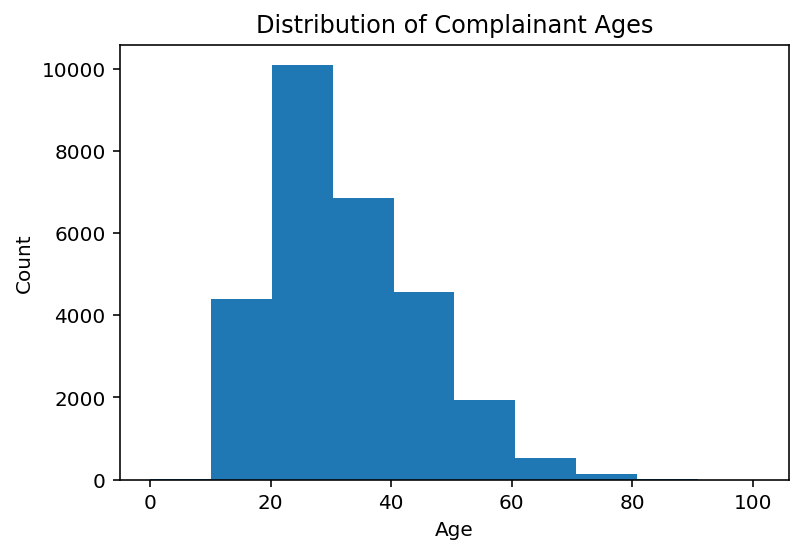

In [199]:
plt.hist(df['complainant_age_incident'])
plt.title('Distribution of Complainant Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Nothing alarming in the histogram. The age column looks good to go!

We now try to get a better sense of the values in the data

In [200]:
df['complainant_ethnicity'].value_counts()

Black              17110
Hispanic            6424
White               2783
Other Race           677
Asian                531
American Indian       64
Name: complainant_ethnicity, dtype: int64

There are relatively far fewer complainants of Asian or American Indian ethnicity so any analyses of those ethnicities specifically has a higher chance of being skewed due to the small sample size. For here on in this project, Asian and American Indian ethnicities will be included in Other.

In [202]:
def merge_ethnicities(arg):
    if arg in ['Asian', 'American Indian']:
        return "Other Race"
    else:
        return arg
df['complainant_ethnicity'] = df['complainant_ethnicity'].apply(merge_ethnicities)

In [204]:
pd.pivot_table(df, columns = ['complainant_ethnicity'], index = ['board_disposition'], aggfunc = "size")


complainant_ethnicity,Black,Hispanic,Other Race,White
board_disposition,,,,
Exonerated,4857,1689,324,697
Substantiated,4073,1572,359,777
Unsubstantiated,8180,3163,589,1309


The above table shows that there a lot more Unsubstantiated cases than other dispositions.

Looking Deeper into ethnicity:

In [304]:
race_comp = (df.groupby('complainant_ethnicity')['complainant_ethnicity'].size() / df.shape[0]).to_frame()
race_comp

,complainant_ethnicity
complainant_ethnicity,
Black,0.513013
Hispanic,0.192612
Other Race,0.038139
White,0.083443


We can see that the majority of complainants in the data set have an ethnicity of Black.

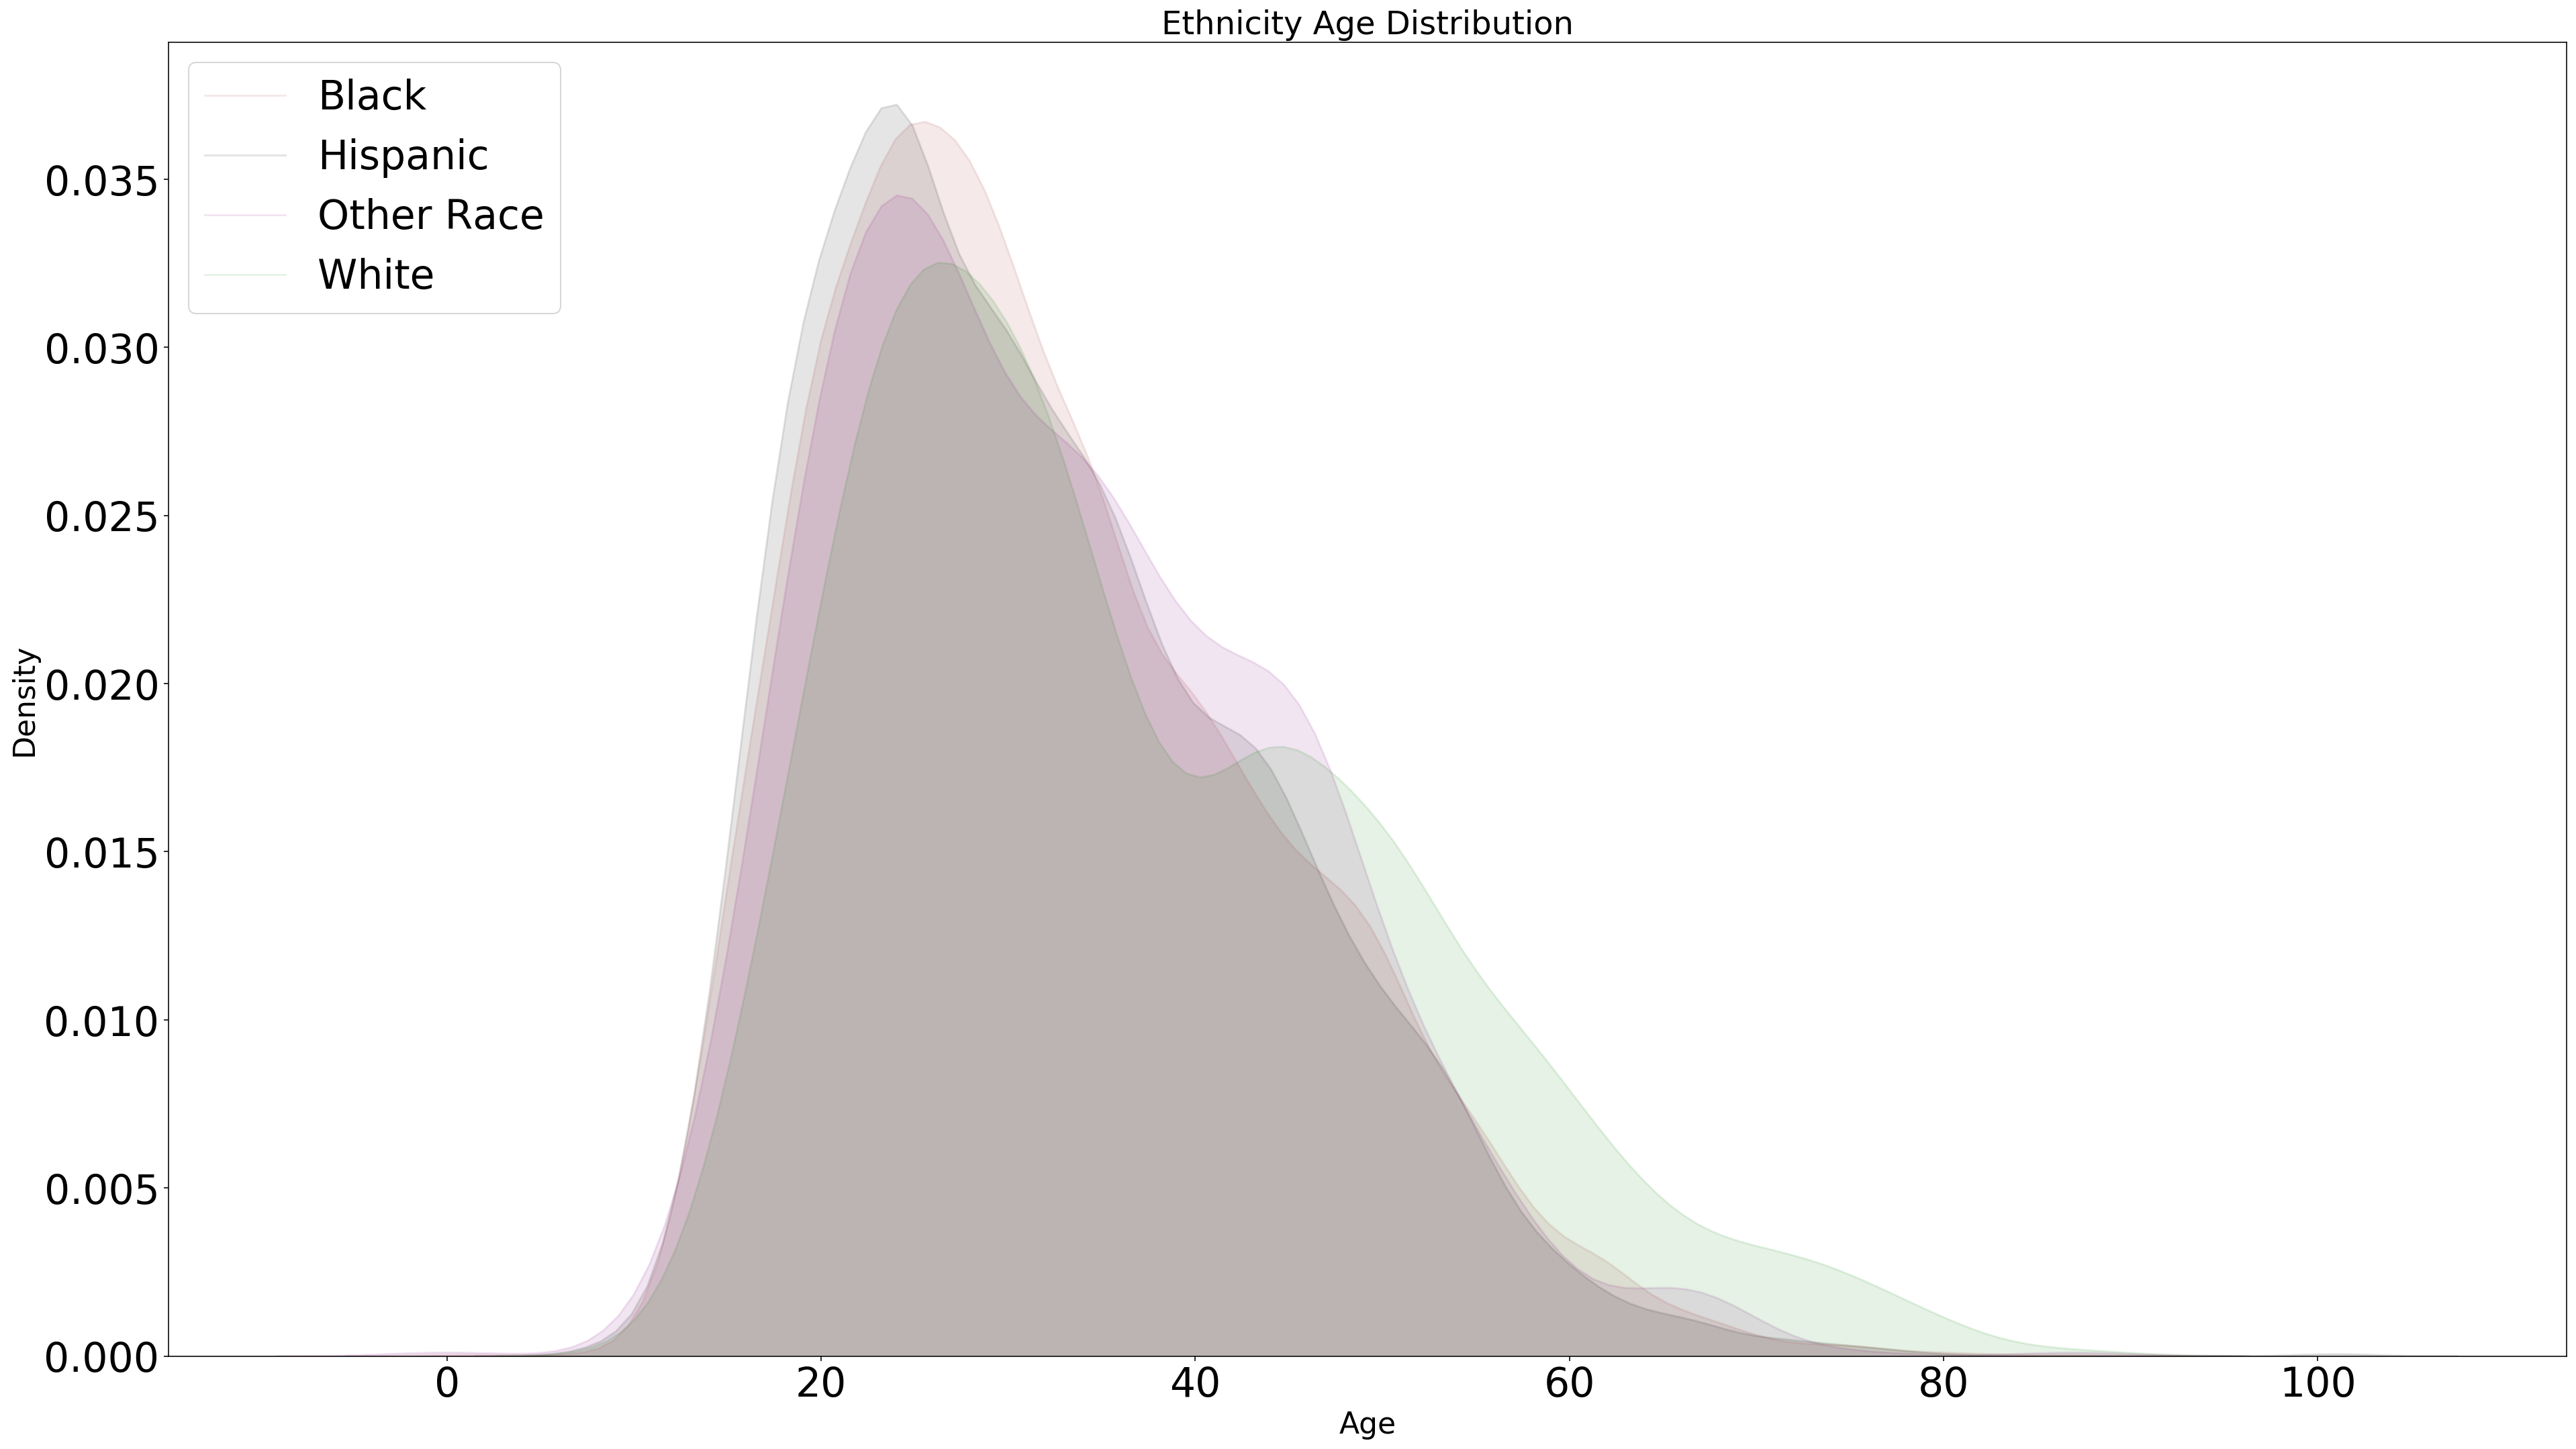

In [312]:
fig, ax = plt.subplots(figsize=(32,18))
# number of colors should be the number of histograms you'll have
colors = ['brown', 'black', 'y', 'g']#, 'blue', 'purple', 'gray', 'black', 'pink', 'teal', 'brown']

ax = sns.kdeplot(df.loc[df['complainant_ethnicity'] == "Black"]["complainant_age_incident"], color='brown', shade=True, alpha=0.1, label = "Black")
ax = sns.kdeplot(df.loc[df['complainant_ethnicity'] == "Hispanic"]["complainant_age_incident"], color='black', shade=True, alpha=0.1, label = "Hispanic")
ax = sns.kdeplot(df.loc[df['complainant_ethnicity'] == "Other Race"]["complainant_age_incident"], color='purple', shade=True, alpha=0.1, label = "Other Race")
ax = sns.kdeplot(df.loc[df['complainant_ethnicity'] == "White"]["complainant_age_incident"], color='g', shade=True, alpha=0.1, label =  "White")
ax.legend(fontsize=30, loc='upper left')
ax.set_title("Ethnicity Age Distribution", fontsize=24)
ax.set_ylabel("Density", fontsize=22)
ax.set_xlabel("Age", fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=30)

This plot shows that the age distributions of each ethnicity are roughly the same.

### Assessment of Missingness

Checking if Complainant_ethnicity is MAR(Missing at Random) dependent on board disposition. We use TVD as test statistic because ethnicity data is nominal and there are more than 2 unique values in the column making TVD the best choice.

Subsetting df to only the necessary columns to increase time efficiency for shuffling:

In [294]:
sub_df = df[['complainant_ethnicity', 'board_disposition', 'precinct', 'complainant_age_incident']].copy(deep=False)

Finding Test Stat:

In [295]:
sub_df['is_null'] = (sub_df['complainant_ethnicity']).isnull()
pt = pd.pivot_table(sub_df, index = ['is_null'] , columns = ['board_disposition'], aggfunc = "size")
false = pt.iloc[0] / pt.sum(axis = 1)[0]
true = pt.iloc[1] / pt.sum(axis = 1)[1]
test_stat = sum(np.abs(false - true)) / 2
test_stat


0.09749795476796386

Simulating 1000 times

In [296]:
obs_arr = np.array([])
for _ in range(1000):
    shuffled_col = sub_df['complainant_ethnicity'].sample(replace=False, frac=1).reset_index(drop=True)
    shuffled = sub_df.assign(**{'is_null' : shuffled_col.isnull()})
    shuff_pt = pd.pivot_table(shuffled, index = ['is_null'], columns = ['board_disposition'], aggfunc = "size")
    shuff_f = shuff_pt.iloc[0] / shuff_pt.sum(axis = 1)[0]
    shuff_t = shuff_pt.iloc[1] / shuff_pt.sum(axis = 1)[1]
    obs_stat = sum(np.abs(shuff_f - shuff_t)) / 2
    obs_arr = np.append(obs_arr, obs_stat)
pval = np.mean(obs_arr >= test_stat)
pval

0.0

Seeing that in 1000 simulations a statistic equal to or more extreme than the observed one was not seen, it is fair to claim that the complainant ethnicity column is MAR dependent on Board Disposition.

We then try another column that should possibly have nothing to do with Board Disposition. Once again, using the test stat of TVD.

In [297]:
sub_df['is_null'] = (sub_df['precinct']).isnull()
pt = pd.pivot_table(sub_df, index = ['is_null'] , columns = ['board_disposition'], aggfunc = "size")
false = pt.iloc[0] / pt.sum(axis = 1)[0]
true = pt.iloc[1] / pt.sum(axis = 1)[1]
test_stat = sum(np.abs(false - true)) / 2
test_stat


0.08453352536405823

In [298]:
obs_arr = np.array([])
for _ in range(1000):
    shuffled_col = sub_df['precinct'].sample(replace=False, frac=1).reset_index(drop=True)
    shuffled = sub_df.assign(**{'is_null' : shuffled_col.isnull()})
    shuff_pt = pd.pivot_table(shuffled, index = ['is_null'], columns = ['board_disposition'], aggfunc = "size")
    shuff_f = shuff_pt.iloc[0] / shuff_pt.sum(axis = 1)[0]
    shuff_t = shuff_pt.iloc[1] / shuff_pt.sum(axis = 1)[1]
    obs_stat = sum(np.abs(shuff_f - shuff_t)) / 2
    obs_arr = np.append(obs_arr, obs_stat)
pval = np.mean(obs_arr >= test_stat)
pval

/Users/aryamansinha/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.


0.655

The observed p-value of 0.655 is pretty high and this indicates the precinct column is Not MAR dependent on Board Disposition.

### Hypothesis Test

We then do a permutation test to explore whether younger complainants are more likely to get Exonerated as their board disposation than Substantiated.

Note: For this hypothesis test we do not care about the 'Unsubstantiated' board dispositions so those will be included in the shuffling but excluded from calculation of test and observed stats. This is because the result of 'Unsubstantiated' does not give us a binary outcome of the complaint.

The test stat we use here will be the difference of means because age is a quantitative variable and the mean should provide a good idea of sample. The mean age of those Exonerated being lower than the same for Substantiated would be a good indicator of whether age plays a role.

Null Hypothesis : Younger complainants get their complaints Exonerated roughly the same as they get it Substantiated

Alternate Hypothesis : Younger complainants are more likely to get their complaints Exonerated than Substantiated

We do a 1-sided alt. hypothesis

Finding Test stat:

In [289]:
mean_exo = sub_df.loc[sub_df['board_disposition'] == "Exonerated"]['complainant_age_incident'].mean()
mean_sub = sub_df.loc[sub_df['board_disposition'] == "Substantiated"]['complainant_age_incident'].mean()
test_stat = mean_exo - mean_sub
test_stat

-0.5473886578693978

Performing 1000 simulations:

In [292]:
obs_stat = np.array([])
for _ in range(1000):
    shuffled_col = sub_df['board_disposition'].sample(replace=False, frac=1).reset_index(drop=True)
    shuffled = sub_df.assign(**{'shuffled_bd' : shuffled_col})
    obs_mean_exo = shuffled.loc[shuffled['shuffled_bd'] == "Exonerated"]['complainant_age_incident'].mean()
    obs_mean_sub = shuffled.loc[shuffled['shuffled_bd'] == "Substantiated"]['complainant_age_incident'].mean()
    obs_stat = np.append(obs_stat, obs_mean_exo - obs_mean_sub)
pval = np.mean(obs_stat <= test_stat)
pval

0.004

With a p-value of 0.004, we reject the null hypothesis in favor of the alternate that Younger complainants are more likely to get their complaints Exonerated than Substantiated.